# Seminário prático - Experimentos sobre meta-aprendizado

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score, f1_score, classification_report, plot_confusion_matrix
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import pandas_datareader.data as pdr
from sklearn.datasets import load_iris
from aux import preprocess_default, ALL_ACC, ALL_ACC_SET, drop_draw_set_class, print_counter
from itertools import combinations
from sklearn.model_selection import StratifiedKFold

In [9]:
data = pd.read_csv("meta-base.csv")
data

,general.attrToInst,general.catToNum,general.freqClass.mean,general.freqClass.sd,general.instToAttr,general.nrAttr,general.nrBin,general.nrCat,general.nrClass,general.nrInst,...,C4.5.auc,kNN.acc,kNN.f1m,kNN.auc,SVM.acc,SVM.f1m,SVM.auc,RF.acc,RF.f1m,RF.auc
0,0.100000,0.000000,0.5,0.471405,10.000000,60,0,0,2,600,...,0.993992,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.042056,0.000000,0.5,0.204863,23.777778,9,0,0,2,214,...,0.786753,0.789214,0.764841,0.879050,0.770022,0.733372,0.835946,0.848485,0.822825,0.916196
2,0.121622,5.000000,0.5,0.066888,8.222222,18,9,15,2,148,...,0.813973,0.807071,0.803779,0.887428,0.846863,0.843160,0.927110,0.866887,0.861265,0.941109
3,0.492063,0.148148,0.5,0.145911,2.032258,31,0,4,2,63,...,0.662129,0.663429,0.680036,0.749489,0.761619,0.750802,0.827020,0.785238,0.771251,0.833724
4,0.020833,0.000000,0.5,0.105224,48.000000,7,2,0,2,336,...,0.959853,0.942531,0.941450,0.977326,0.966627,0.965831,0.985190,0.965199,0.964476,0.987683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.223881,0.071429,0.5,0.158307,4.466667,15,1,1,2,67,...,0.779784,0.768214,0.757795,0.843975,0.697202,0.701777,0.808815,0.798333,0.784645,0.858558
396,0.003472,0.000000,0.5,0.283170,288.000000,6,0,6,2,1728,...,0.982767,0.877835,0.844500,0.955360,0.957931,0.950636,0.993741,0.989701,0.987869,0.999346
397,0.021277,0.000000,0.5,0.342688,47.000000,18,0,0,2,846,...,0.969553,0.970795,0.962234,0.993139,0.979193,0.972641,0.996332,0.986998,0.982835,0.998817
398,0.023500,0.000000,0.5,0.565685,42.553191,47,0,0,2,2000,...,0.981546,0.993950,0.983220,0.998558,0.994550,0.984556,0.999174,0.988250,0.965376,0.998578


# Primeiro experimento - 5 Classes

In [10]:
#remove as colunas referentes às medidas f1m e auc
data.drop(data.filter(regex='(.*?\.auc|.*?\.f1m)').columns, axis=1, inplace=True)
data.loc[:, ['landmarking.randomNode.sd', 'landmarking.worstNode.mean', 'landmarking.worstNode.sd', 'ANN.acc', 
             'C4.5.acc', 'kNN.acc', 'SVM.acc', 'RF.acc']]

,landmarking.randomNode.sd,landmarking.worstNode.mean,landmarking.worstNode.sd,ANN.acc,C4.5.acc,kNN.acc,SVM.acc,RF.acc
0,0.038789,0.886667,0.041425,1.000000,0.992000,1.000000,1.000000,1.000000
1,0.089963,0.617662,0.076761,0.708379,0.784846,0.789214,0.770022,0.848485
2,0.123754,0.560536,0.119251,0.837292,0.792357,0.807071,0.846863,0.866887
3,0.160420,0.639048,0.171734,0.767238,0.646000,0.663429,0.761619,0.785238
4,0.110580,0.604069,0.075009,0.961919,0.949307,0.942531,0.966627,0.965199
...,...,...,...,...,...,...,...,...
395,0.160472,0.636310,0.179899,0.770893,0.765179,0.768214,0.697202,0.798333
396,0.018734,0.700249,0.018734,0.999768,0.950167,0.877835,0.957931,0.989701
397,0.041359,0.742169,0.042820,0.982605,0.962633,0.970795,0.979193,0.986998
398,0.008433,0.900000,0.000000,0.994850,0.983450,0.993950,0.994550,0.988250


In [11]:
#remove as amostras com empate (com relação à maior acurácia) e determina as classes
data = drop_draw_set_class(data)
data.loc[:, ['landmarking.randomNode.mean', 'landmarking.randomNode.sd', 'landmarking.worstNode.mean', 'landmarking.worstNode.sd', 'Class']]

,landmarking.randomNode.mean,landmarking.randomNode.sd,landmarking.worstNode.mean,landmarking.worstNode.sd,Class
0,0.655297,0.089963,0.617662,0.076761,RF.acc
1,0.593000,0.123754,0.560536,0.119251,RF.acc
2,0.569762,0.160420,0.639048,0.171734,RF.acc
3,0.674139,0.110580,0.604069,0.075009,SVM.acc
4,0.648228,0.142807,0.643772,0.147598,ANN.acc
...,...,...,...,...,...
378,0.676190,0.160472,0.636310,0.179899,RF.acc
379,0.700249,0.018734,0.700249,0.018734,ANN.acc
380,0.752254,0.041359,0.742169,0.042820,RF.acc
381,0.903000,0.008433,0.900000,0.000000,ANN.acc


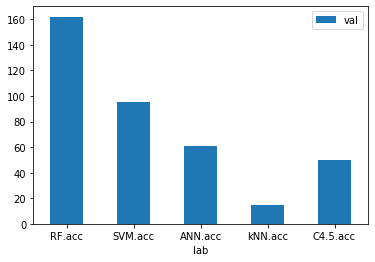

In [13]:
#plota distribuição das classes
X = data.drop('Class', axis=1)

y = data['Class']

vec = list(zip( *[*Counter( y ).items()])) 
gambs = pd.DataFrame(dict(zip(['lab', 'val'],vec))) 
ax = gambs.plot.bar(x='lab', y='val', rot=0) 
plt.show(block=True)

In [14]:
Counter(y)

Counter({'RF.acc': 162,
         'SVM.acc': 95,
         'ANN.acc': 61,
         'kNN.acc': 15,
         'C4.5.acc': 50})

Fold  1
Accuracy: 0.40625 

Confusion matrix


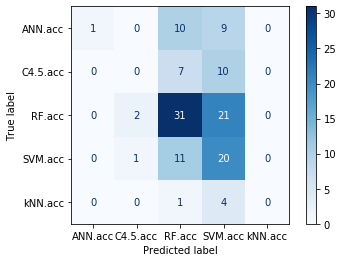


 

Fold  2
Accuracy: 0.4453125 

Confusion matrix


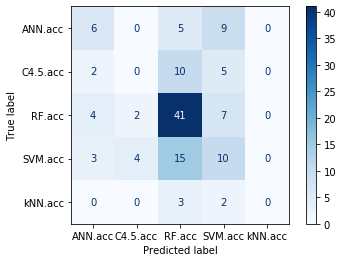


 

Fold  3
Accuracy: 0.49606299212598426 

Confusion matrix


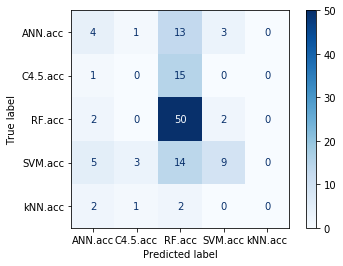


 

------------------------
Considered classes : All 

Mean accuracy =  0.4492084973753281 



In [49]:
rfc = RandomForestClassifier(n_estimators=1000)
k = 0
acc = 0
acc_sum = 0   
n_splits = 3

skf = StratifiedKFold(n_splits=n_splits)
features_list = []
for train_index, test_index in skf.split(X, y):
      k += 1  
      print("Fold ", k)
      rfc.fit(X.loc[train_index, :].drop('index', axis=1), y.loc[train_index])
      features_list.append(rfc.feature_importances_)
      y_pred = rfc.predict(X.loc[test_index, :].drop('index', axis=1), )

      #avaliação da predição

      #acurácia
      acc = accuracy_score(y_true=y.loc[test_index], y_pred=y_pred)
      acc_sum += acc
      print(f"Accuracy: {acc} \n")

      #matriz de confusão
      print("Confusion matrix")  
      disp = plot_confusion_matrix(rfc, X.loc[test_index, :].drop('index', axis=1), y.loc[test_index],
                                 display_labels=None,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
      plt.show()
      print("\n \n")

      


#printa as médias das medidas tiradas nos 10 folds
print("------------------------")
print("Considered classes : All \n")
print("Mean accuracy = ", acc_sum / n_splits, "\n")

In [53]:
# print(len(X.columns))
# print(len(features_list[0]))
# print(*zip(X.columns[1:], features_list[0]))

for idx, ft_lis in enumerate(features_list):
    print(f"{idx} |----> ")
    for i, j in sorted(zip(X.columns[1:], ft_lis), key = lambda x : x[1], reverse=True)[:10]:
        print(i, ' -> ', j)
    print("\n")
#     break


0 |----> 
infotheo.attrConc.sd  ->  0.018340393350282837
landmarking.eliteNN.mean  ->  0.016895236757545652
model.based.varImportance.mean  ->  0.01677765043031707
model.based.nodesPerAttr  ->  0.015965382659721417
model.based.varImportance.sd  ->  0.015251732258058417
landmarking.oneNN.mean  ->  0.014986902380812956
model.based.treeShape.sd  ->  0.014397500048930012
infotheo.classConc.sd  ->  0.01395538938337157
general.nrAttr  ->  0.01384215833100849
statistical.nrNorm  ->  0.013827459507457273


1 |----> 
model.based.varImportance.mean  ->  0.022458886378921523
general.nrAttr  ->  0.021860158116943307
infotheo.eqNumAttr  ->  0.01837071883272661
statistical.nrNorm  ->  0.01813524832842709
infotheo.attrConc.sd  ->  0.01727201136251452
general.nrNum  ->  0.015760821293558793
landmarking.naiveBayes.mean  ->  0.015366046614917216
landmarking.oneNN.mean  ->  0.015263825221731902
infotheo.mutInf.sd  ->  0.015058659239472404
landmarking.linearDiscr.mean  ->  0.014507802154911235


2 |----> 

In [28]:
print('errrr - ', len(X.columns))
print('dddd - ', len(features_list[0]))

errrr -  109
dddd -  109


# Segundo experimento - Classes dois a dois

Considered classes
RF.acc -> 246
SVM.acc -> 151


Fold  1
Accuracy: 0.46616541353383456 



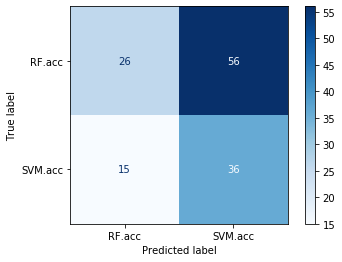


 

Fold  2
Accuracy: 0.6666666666666666 



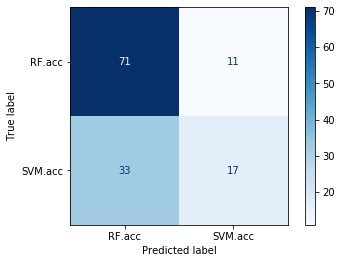


 

Fold  3
Accuracy: 0.6818181818181818 



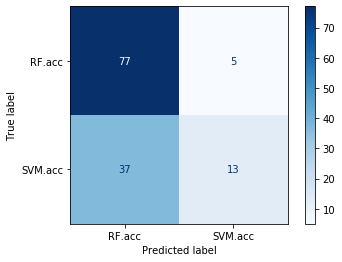


 

Mean accuracy =  0.6048834206728944 

-----------------------

Considered classes
RF.acc -> 304
C4.5.acc -> 89


Fold  1
Accuracy: 0.8091603053435115 



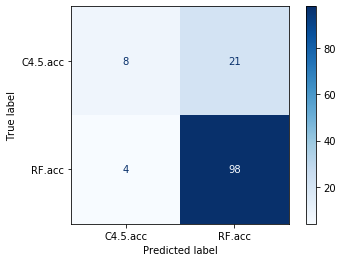


 

Fold  2
Accuracy: 0.7709923664122137 



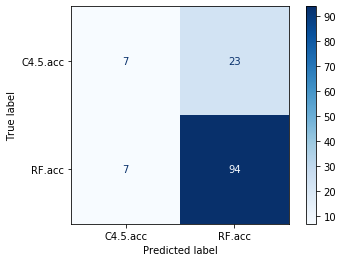


 

Fold  3
Accuracy: 0.7938931297709924 



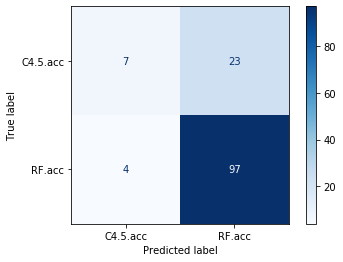


 

Mean accuracy =  0.7913486005089059 

-----------------------

Considered classes
SVM.acc -> 230
C4.5.acc -> 165


Fold  1
Accuracy: 0.6287878787878788 



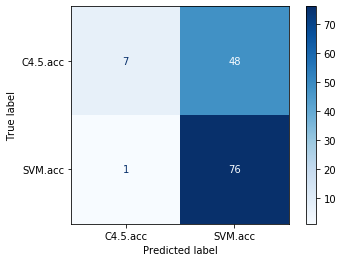


 

Fold  2
Accuracy: 0.6893939393939394 



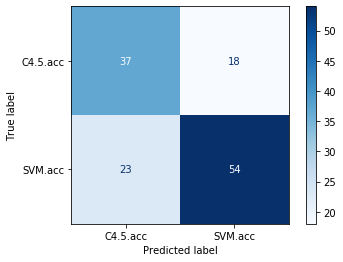


 

Fold  3
Accuracy: 0.6335877862595419 



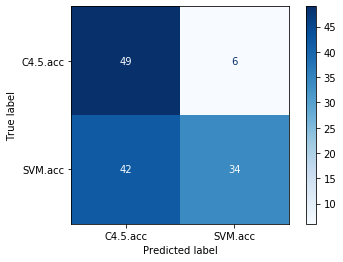


 

Mean accuracy =  0.65058986814712 

-----------------------

Considered classes
RF.acc -> 347
kNN.acc -> 49


Fold  1
Accuracy: 0.8636363636363636 



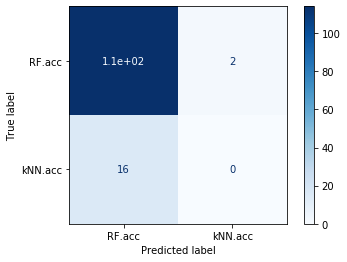


 

Fold  2
Accuracy: 0.8712121212121212 



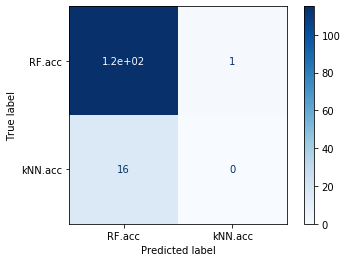


 

Fold  3
Accuracy: 0.8712121212121212 



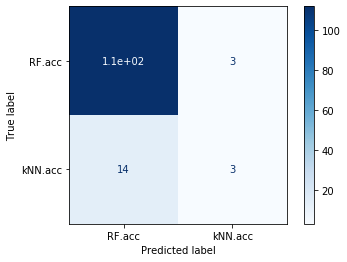


 

Mean accuracy =  0.8686868686868686 

-----------------------

Considered classes
kNN.acc -> 79
SVM.acc -> 317


Fold  1
Accuracy: 0.7878787878787878 



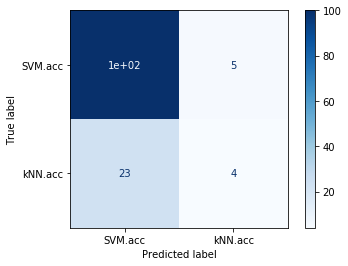


 

Fold  2
Accuracy: 0.8257575757575758 



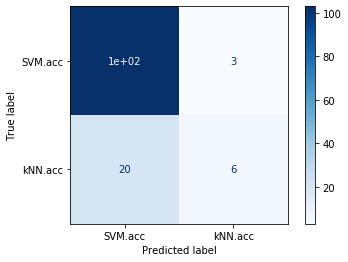


 

Fold  3
Accuracy: 0.8181818181818182 



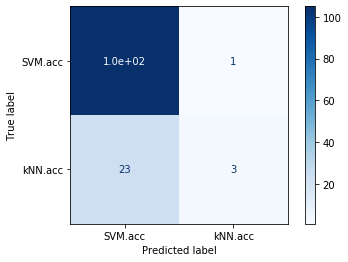


 

Mean accuracy =  0.8106060606060607 

-----------------------

Considered classes
kNN.acc -> 120
C4.5.acc -> 277


Fold  1
Accuracy: 0.706766917293233 



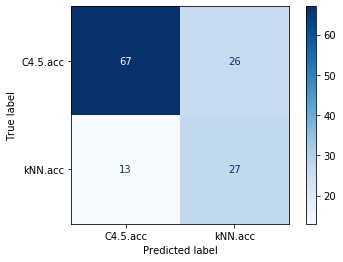


 

Fold  2
Accuracy: 0.7803030303030303 



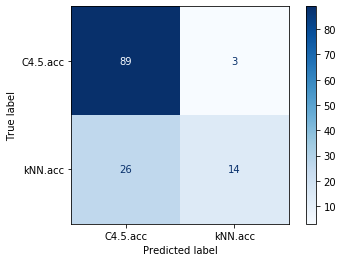


 

Fold  3
Accuracy: 0.7575757575757576 



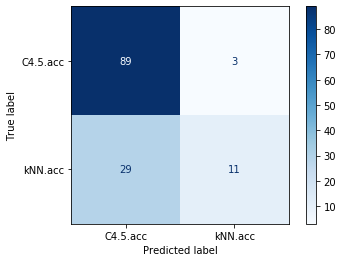


 

Mean accuracy =  0.7482152350573402 

-----------------------

Considered classes
RF.acc -> 271
ANN.acc -> 118


Fold  1
Accuracy: 0.6846153846153846 



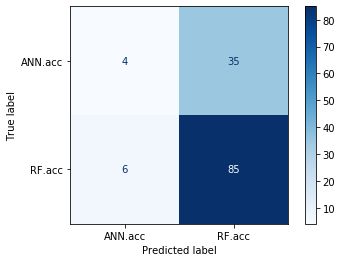


 

Fold  2
Accuracy: 0.7230769230769231 



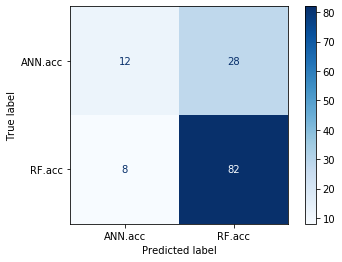


 

Fold  3
Accuracy: 0.7131782945736435 



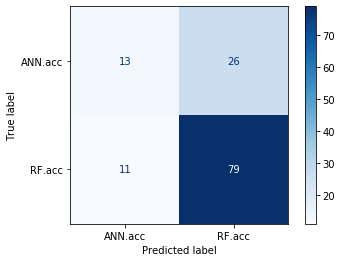


 

Mean accuracy =  0.7069568674219836 

-----------------------

Considered classes
SVM.acc -> 225
ANN.acc -> 170


Fold  1
Accuracy: 0.5984848484848485 



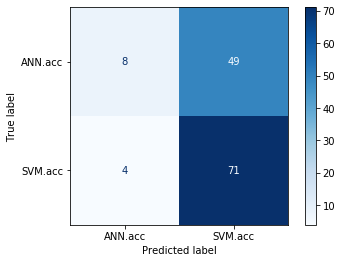


 

Fold  2
Accuracy: 0.6287878787878788 



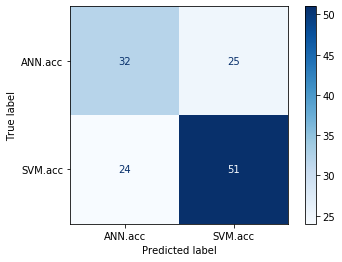


 

Fold  3
Accuracy: 0.5114503816793893 



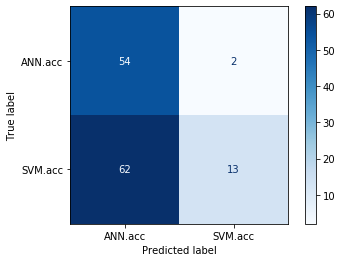


 

Mean accuracy =  0.5795743696507055 

-----------------------

Considered classes
ANN.acc -> 214
C4.5.acc -> 178


Fold  1
Accuracy: 0.6717557251908397 



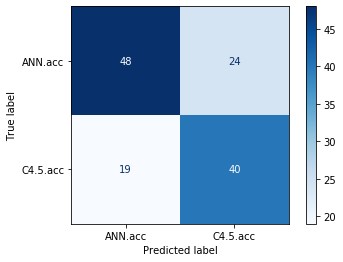


 

Fold  2
Accuracy: 0.7251908396946565 



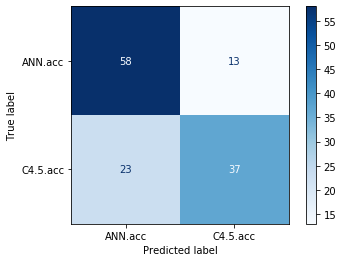


 

Fold  3
Accuracy: 0.7076923076923077 



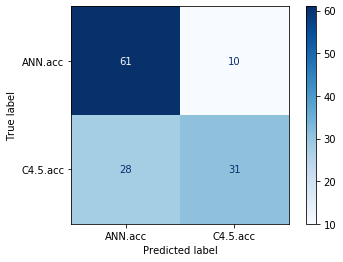


 

Mean accuracy =  0.7015462908592679 

-----------------------

Considered classes
kNN.acc -> 82
ANN.acc -> 313


Fold  1
Accuracy: 0.5833333333333334 



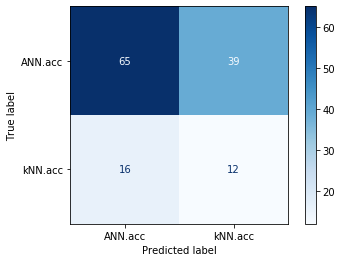


 

Fold  2
Accuracy: 0.8181818181818182 



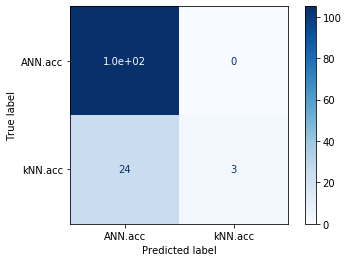


 

Fold  3
Accuracy: 0.7938931297709924 



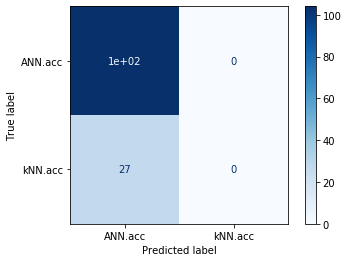


 

Mean accuracy =  0.7318027604287147 

-----------------------



In [7]:
comb_to_drop = list(combinations(ALL_ACC, r=3))
raw = pd.read_csv('meta-base.csv')

classifiers_list = []
acc_mean_list = []

#para cada combinação de 3 colunas, dropa essas 3 deixando 2 colunas para o problema de classificação
#faz o pre_processamento do dataframe passando as colunas consideradas (retira os empates e seta as classes)
#divide o data em features e rótulo e divide os folds
for to_drop in comb_to_drop:
    data = raw.drop(list(to_drop), axis=1)
    considered_classes = ALL_ACC_SET - set(to_drop)
    data = preprocess_default(data, list(considered_classes))
    rfc = RandomForestClassifier(n_estimators=200)
    X = data.drop('Class', axis=1)
    y = data['Class']
    k = 0
    n_splits = 3
    skf = StratifiedKFold(n_splits=n_splits)
    acc = 0
    acc_sum = 0
    classifiers_list.append([])
    print("Considered classes")
    print_counter(y)
    print("\n")
    
    for train_index, test_index in skf.split(X, y):
        k += 1
        print("Fold ", k)
        rfc.fit(X.loc[train_index, :], y.loc[train_index])
        y_pred = rfc.predict(X.loc[test_index, :], )

        #avaliação da predição

        #acurácia
        acc = accuracy_score(y_true=y.loc[test_index], y_pred=y_pred)
        acc_sum += acc
        print(f"Accuracy: {acc} \n")

        #matriz de confusão
        disp = plot_confusion_matrix(rfc, X.loc[test_index, :], y.loc[test_index],
                                 display_labels=None,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
        plt.show()
        print("\n \n")

        classifiers_list[-1].append(rfc)

        
    
    print("Mean accuracy = ", acc_sum / n_splits, "\n")
    acc_mean_list.append(acc_sum / n_splits)
    print("-----------------------\n")
 
    